In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime

In [34]:
#combine all CSV files into one dataframe, and add a column for city 

root = '/Users/camille/Documents/ds_intern'

df_dict = {}
for file in os.listdir(root):
    if file.endswith(".csv"):
        name = os.path.splitext(file)[0]
        df_dict[name] = pd.read_csv(os.path.join(root, file))
        df_dict[name]['city'] = name
        
weather_df = pd.concat(df_dict.values(), axis=0, ignore_index=True)

weather_df.head()

,date,actual_mean_temp,actual_min_temp,actual_max_temp,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,actual_precipitation,average_precipitation,record_precipitation,city
0,2014-7-1,83,72,93,68,86,52,102,1988.0,1901.0,0.00,0.13,1.04,KPHL
1,2014-7-2,86,75,96,68,86,52,103,1965.0,1901.0,0.21,0.13,1.73,KPHL
2,2014-7-3,83,74,92,68,87,54,104,1957.0,1966.0,0.09,0.12,3.66,KPHL
3,2014-7-4,73,68,78,68,87,52,103,1986.0,1966.0,0.04,0.13,2.08,KPHL
4,2014-7-5,74,64,83,69,87,55,100,1963.0,1999.0,0.00,0.13,4.38,KPHL


In [35]:
#create a new column to translate the city code into the city name for better readability

cities = ['KPHL', 'KNYC', 'KPHX', 'KCQT', 'KHOU', 'KMDW', 'KJAX', 'KIND', 'KSEA', 'KCLT']

city_names = ['Philadelphia', 'New York City', 'Phoenix', 'Los Angeles', 
              'Houston', 'Chicago', 'Jacksonville', 'Indianapolis', 'Seattle', 
              'Charlotte']

city_dict = dict(zip(cities, city_names))

weather_df['city_name'] = weather_df['city'].map(city_dict)


Text(0, 0.5, 'Precipitation')

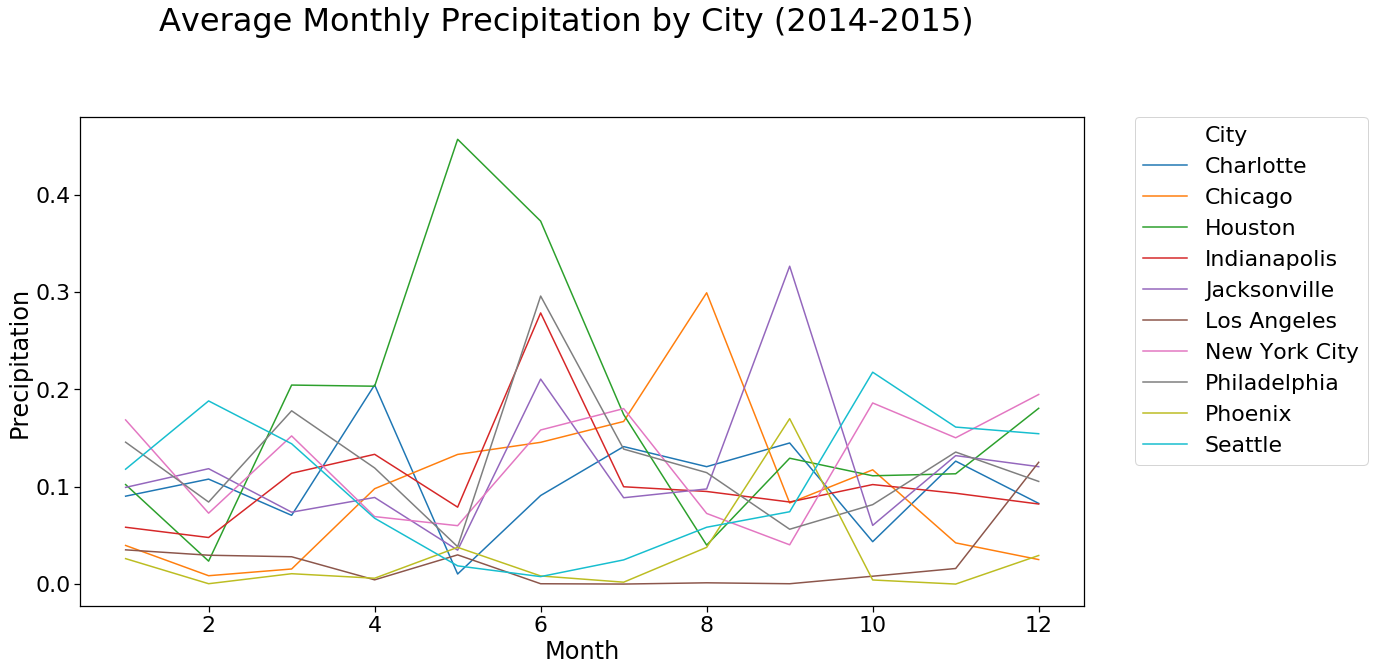

In [36]:
#create a column for month
weather_df['month'] = weather_df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)

#create a dataframe showing the average actual precipitation per month
precip_by_month = weather_df.groupby(['city_name','month'])['actual_precipitation'].mean().to_frame('mean_actual_precipitation').reset_index()


plt.figure(figsize=(18,9))
sns.lineplot(data=precip_by_month, x="month", y="mean_actual_precipitation", hue="city_name")
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend.texts[0].set_text("City")
plt.suptitle("Average Monthly Precipitation by City (2014-2015)", y=1.05, fontsize=32)
plt.xlabel("Month")
plt.ylabel("Precipitation")

Text(0, 0.5, 'Precipitation')

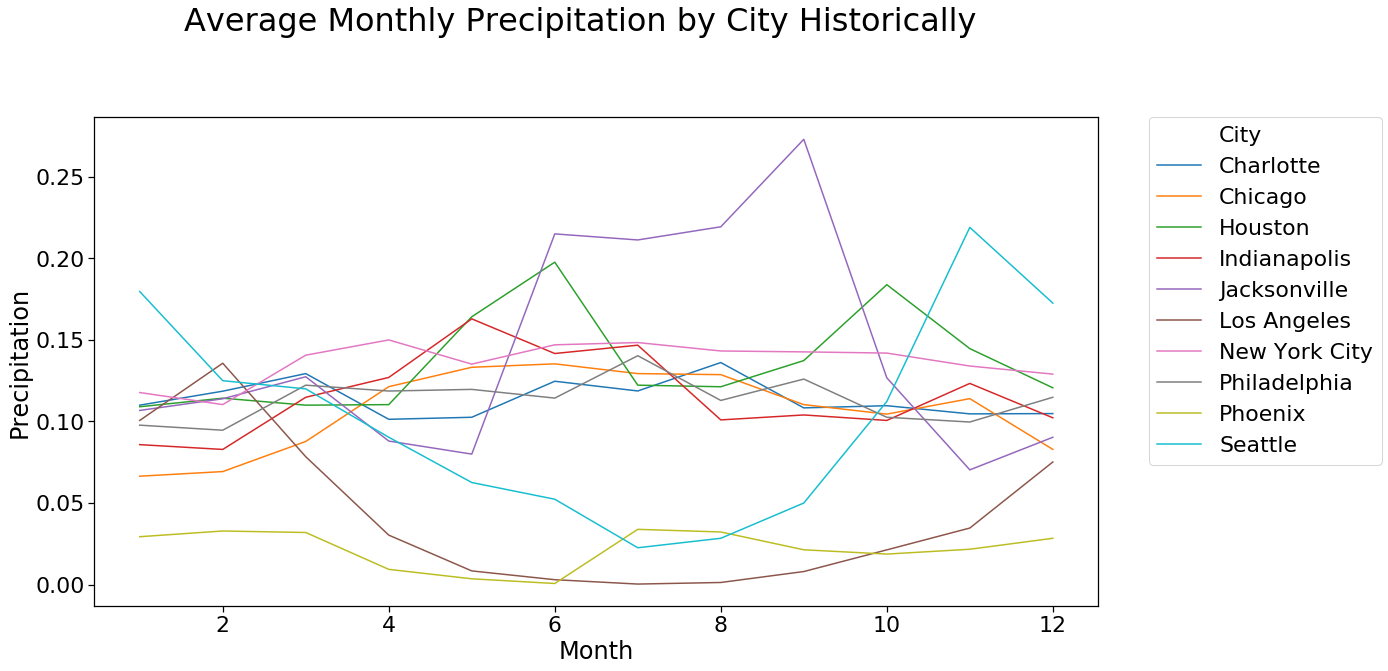

In [37]:
#create a dataframe and plot to view the average monthly precipitation for previous years

past_precip = weather_df.groupby(['city_name','month'])['average_precipitation'].mean().to_frame('mean_average_precipitation').reset_index()

plt.figure(figsize=(18,9))
sns.lineplot(data=past_precip, x="month", y="mean_average_precipitation", hue="city_name")
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend.texts[0].set_text("City")
plt.suptitle("Average Monthly Precipitation by City Historically", y=1.05, fontsize=32)
plt.xlabel("Month")
plt.ylabel("Precipitation")

In [38]:
#lets compare Houston's actual precipitation with its historical precipitation

houston_actual_precip = weather_df[weather_df['city_name'] == 'Houston']['actual_precipitation']
print('Houston actual mean:')
print(houston_actual_precip.mean())
print('Houston actual variance:')
print(houston_actual_precip.var())


houston_average_precip = weather_df[weather_df['city_name'] == 'Houston']['average_precipitation']
print('Houston historical mean:')
print(houston_average_precip.mean())
print('Houston historical variance:')
print(houston_average_precip.var())


Houston actual mean:
0.17698630136986307
Houston actual variance:
0.2555689146469968
Houston historical mean:
0.1363561643835616
Houston historical variance:
0.0010138837874454317


In [39]:
#conduct a t-test to compare means

from scipy.stats import ttest_ind

t, p = ttest_ind(houston_actual_precip, houston_average_precip, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

#with a p-value above 0.05, we fail to reject the null hypothesis that this year's precipitation in Houston was
#significantly different than the previous years.

ttest_ind:            t = 1.53243  p = 0.126278


In [40]:
#create a column signifying whether a day was hot (at or over 85 degrees) or not
weather_df['hot'] = np.where(weather_df['actual_max_temp'] >= 85, True, False)

#create a column signifying whether a day was freezing (at or below 32 degrees) or not
weather_df['freezing'] = np.where(weather_df['actual_min_temp'] <= 32, True, False)

#create a column signifying whether a day had precipitation or not
weather_df['precipitation'] = np.where(weather_df['actual_precipitation'] > 0, True, False)

In [41]:
#create a new dataframe showing the percentage of each type of day each city has

rankings_df = pd.DataFrame(columns = ['city_name', 'hot_perc', 'freezing_perc', 'precip_perc'])

for city in city_names:
    hot_count = weather_df[(weather_df['city_name'] == city)]['hot'].value_counts(normalize=True)
    hot_perc = (hot_count.get(True, 0))*100
    freezing_count = weather_df[(weather_df['city_name'] == city)]['freezing'].value_counts(normalize=True)
    freezing_perc = (freezing_count.get(True, 0)) *100 
    precip_count = weather_df[(weather_df['city_name'] == city)]['precipitation'].value_counts(normalize=True)
    precip_perc = (precip_count.get(True, 0)) *100
    rankings_df = rankings_df.append({'city_name': city, 'hot_perc' : hot_perc, 
                                      'freezing_perc': freezing_perc,
                                      'precip_perc': precip_perc}, ignore_index=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

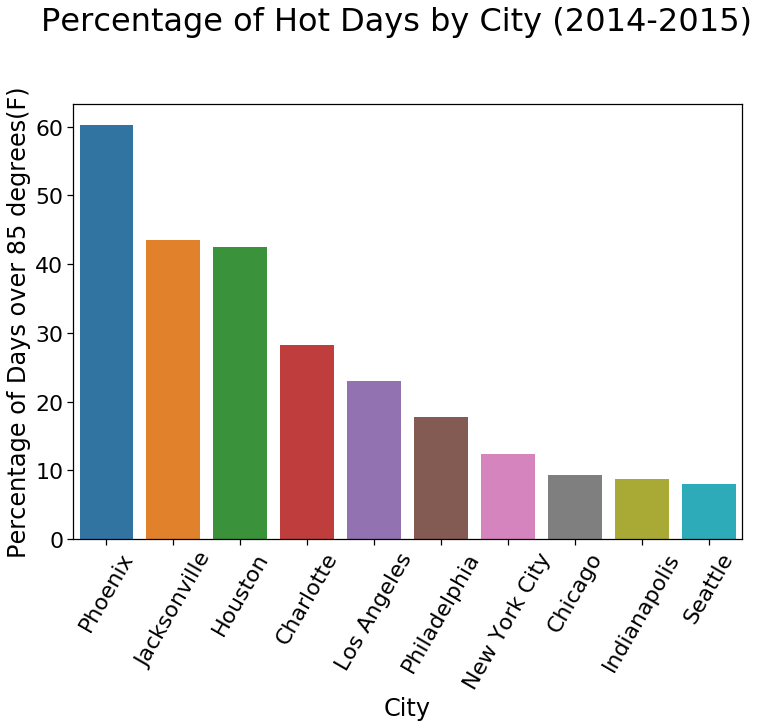

In [42]:
#plot the percentage of hot days by city

plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=2)
result = rankings_df.sort_values(by='hot_perc', ascending=False).reset_index(drop=True) 
sns.barplot(data =result, x="city_name", y="hot_perc")
plt.suptitle("Percentage of Hot Days by City (2014-2015)", y=1.05, fontsize=32)
plt.xlabel("City")
plt.ylabel("Percentage of Days over 85 degrees(F)")
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

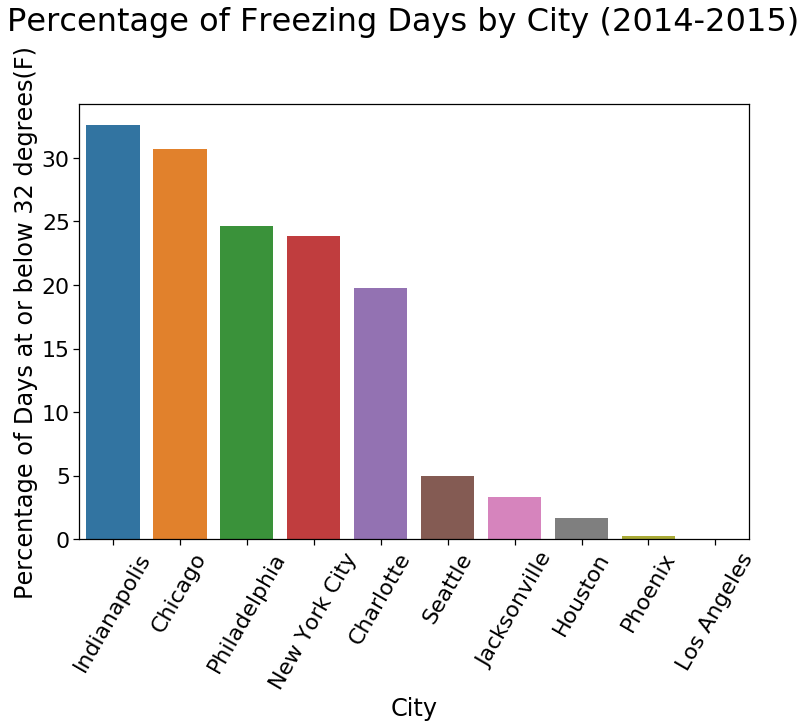

In [43]:
#plot the percentage of freezing days by city

plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=2)
result = rankings_df.sort_values(by='freezing_perc', ascending=False).reset_index(drop=True) 
sns.barplot(data =result, x="city_name", y="freezing_perc")
plt.suptitle("Percentage of Freezing Days by City (2014-2015)", y=1.05, fontsize=32)
plt.xlabel("City")
plt.ylabel("Percentage of Days at or below 32 degrees(F)")
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

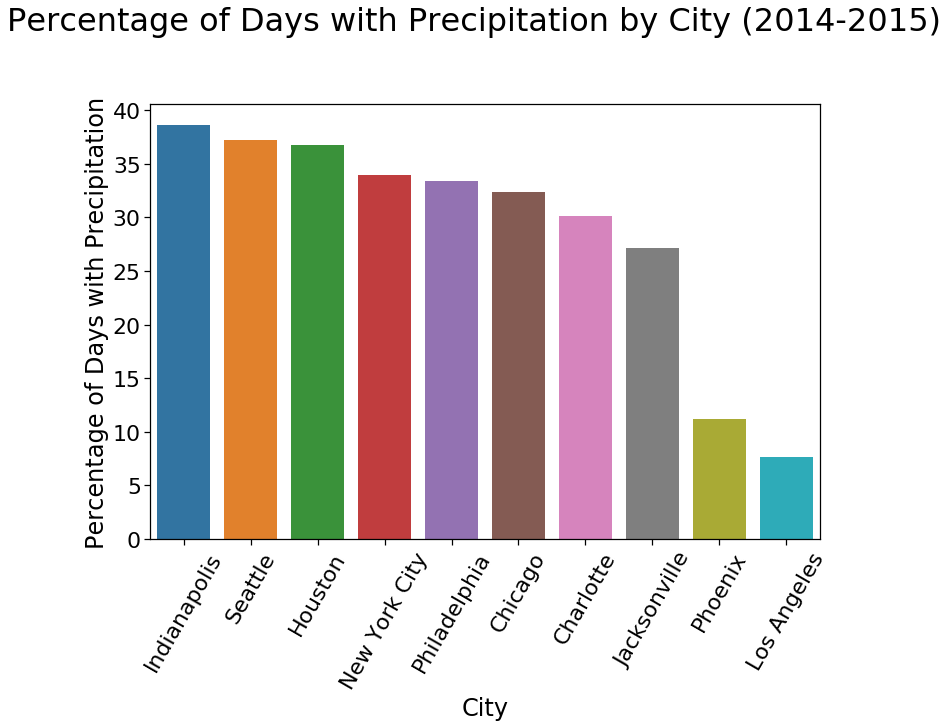

In [44]:
#plot the percentage of days with precipitation by city

plt.figure(figsize=(12,8))
sns.set_context("notebook", font_scale=2)
result = rankings_df.sort_values(by='precip_perc', ascending=False).reset_index(drop=True) 
sns.barplot(data =result, x="city_name", y="precip_perc")
plt.suptitle("Percentage of Days with Precipitation by City (2014-2015)", y=1.05, fontsize=32)
plt.xlabel("City")
plt.ylabel("Percentage of Days with Precipitation")
plt.xticks(rotation=60)